MIRI LRS Slit Mode: Pipeline Reprocessing Demo
================================================

This notebook will demonstrate how to reprocess MIRI LRS slit mode data, in case changes need to be made to the pipeline settings. The goal of this notebook is to provide code to reprocess the data using default settings. We will provide tips for how to modify settings, however we do not delve into any particular steps. 

To learn more about specific steps of the pipeline for LRS and how to optimize the data reduction, please see the accompanying notebooks in this repository. 


### Dependencies
- os
- jwst
- astropy
- glob 

### Assumptions
- we will start from the `rate.fits` file stage, assuming the Detector1Pipeline has executed successfully. LRS slit data generally do not require custom settings or changes to the Stage 1 pipeline. 
- we assume the data were executed with the ALONG SLIT NOD dither pattern, and that the nods will be mutually subtracted for background subtraction


### Versions
The notebook was developed using JWST calibration pipeline version 1.12.3 and CRDS context jwst_1147.pmap. 

### Getting help
If you have questions or feedback about this notebook, please contact the MIRI team via the [JWST Helpdesk](https://jwsthelp.stsci.edu/), directing the query to the MIRI team. 


In [1]:
import glob
import os
os.environ['CRDS_CONTEXT'] = 'jwst_1147.pmap'



In [2]:
%matplotlib inline
import numpy as np
import astropy
import matplotlib.pyplot as plt

import jwst
print('Importing JWST pipeline version {}'.format(jwst.__version__))
from jwst.pipeline import Spec2Pipeline, Spec3Pipeline
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst import datamodels


Importing JWST pipeline version 1.12.3


## 1.  Loading data and Creating the Level 2 Association. 

First of all we will locate the data. This notebook uses a flux calibrator observation (PID 1538, Obs 21), but you can replace the file identifications below with your own files. 

For datasets where the 2 nod exposures will be used as each other's backgrounds, we have to build an association indicating the relationship between the files. Association files can also be retrieved from MAST for your program. 

**Alternative strategy**: individual nods can also be run through the Spec2Pipeline to be processed and calibrated as individual files. In this case, no association file is needed, and each individual file can be passed to teh Spec2Pipeline. 

In [3]:
nod1_file = 'data/jw01538021001_05101_00001_mirimage_rate.fits'
nod2_file = 'data/jw01538021001_05101_00002_mirimage_rate.fits'
nods_list = [nod1_file, nod2_file]



In [4]:
# The metdata for the association file is optional
asn = asn_from_list(nods_list, rule=DMSLevel2bBase, meta={'program':'01538', 'asn_id': 'o021', 'target':'GSPC P330E', 'asn_pool':'None'})
print(asn)

Association jw01538-o999_none_00002_asn
    Parameters:        Product type: indetermined        Rule:         indetermined        Program:      indetermined        Target:       indetermined        Pool:         indetermined
        
	data/jw01538021001_05101_00001_mirimage with 1 members
	data/jw01538021001_05101_00002_mirimage with 1 members




The association now contains 2 _members_. We now associate each member with the opposing nod, assigning it as background. 

In [5]:
asn['products'][0]['name'] = (nod1_file.split('/')[-1]).replace('_rate.fits', '')
asn['products'][1]['name'] = (nod2_file.split('/')[-1]).replace('_rate.fits', '')
asn['products'][0]['members'].append({'expname': nod2_file, 'exptype':'background'})
asn['products'][1]['members'].append({'expname': nod1_file, 'exptype':'background'})

print(asn)

# write this out to a json file
with open('lrs_slit_end2end_spec2asn.json', 'w') as fp:
    fp.write(asn.dump()[1])

2023-11-13 19:03:40,926 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst1.12.3/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-13 19:03:40,926 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-13 19:03:40,927 - stpipe - WARNING - 


Association jw01538-o999_none_00002_asn
    Parameters:        Product type: indetermined        Rule:         indetermined        Program:      indetermined        Target:       indetermined        Pool:         indetermined
        
	jw01538021001_05101_00001_mirimage with 2 members
	jw01538021001_05101_00002_mirimage with 2 members




## 2. Running the Spec2Pipeline

The Spec2Pipeline takes the association file as input, and performs the following operations:
* `assign_wcs`: assigns the WCS information, as well as the wavelength calibration (reference file: specwcs). This step also assigns a bounding box region over which the data will be calibrated.
* `bkg_subtract`: subtracts the background. in our demo case, this will subtract the nods from each other, resulting in 2 files, each with a negative and a positive trace. 
* `srctype`: assigns the source type. this information is inherited from the target info in APT and this determines the aperture settings for spectral extraction. for MIRI LRS the default is 'point'. 
* `flat_field`: the flat field is divided out (reference file: flat)
* `pathloss`: the data are corrected for slit losses. **see the miri_lrs_pathloss.ipynb notebook for additional comments about the path loss step**. (reference file: pathloss)
* `photom`: photometric calibration factors are applied (reference file: photom)
* `pixel_replace`: pixels set to DO_NOT_USE in the DQ array within the bounding box region are replaced by interpolation to prevent spurious spikes in the extracted products. 
* `resample_spec`: the spectrum is resampled and rectified. At this step the output product contains the bounding box region only, not the full array. 
* `extract_1d`: the spectrum is extracted from the 2D spectral image.

These steps are all run by default for MIRI LRS data. We will put them all explicitly in the call for clarity. 

**NOTE: at this pipeline stage, the resampled and extracted data products are for "sanity check" purposes only. For this end to end demo, we will set these steps to be skipped. To run the steps and inspect the outputs, set 'skip' for each step to 'True' in the call below.**

In [6]:
sp2_asnfile = 'lrs_slit_end2end_spec2asn.json'
sp2_out = Spec2Pipeline.call(sp2_asnfile, save_results=True, output_dir='data/', steps={
                                'assign_wcs': {'skip': False},
                                'bkg_subtract': {'skip': False},
                                'srctype': {'skip': False},
                                'flat_field': {'skip': False},
                                'pathloss': {'skip': False},
                                'photom': {'skip': False},
                                'pixel_replace': {'skip': False},
                                'resample_spec': {'skip': True},
                                'extract_1d': {'skip': True}})


2023-11-13 19:03:41,379 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst1.12.3/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-13 19:03:41,379 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-13 19:03:41,380 - stpipe - WARNING - 
2023-11-13 19:03:42,814 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-13 19:03:42,818 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_pars-spec2pipeline_0006.asdf
2023-11-13 19:03:42,837 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-13 19:03:42,838 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-13 19:03:42,839 - stpipe.Spec2Pipeline.assign_wcs - INFO

As we skipped the resampling and extraction steps, the final output products are `cal.fits` files, which are wavelength calibrated and photometrically calibrated, still in FULL array format. Let's visualize the output. 

The output variable `sp2_out` is a list of 2 ImageModels representing these 2 calibrated output files. 

2023-11-13 19:03:49,575 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_99104/2002496584.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
2023-11-13 19:03:49,576 - stpipe - WARNING -   fig.show()
2023-11-13 19:03:49,576 - stpipe - WARNING - 


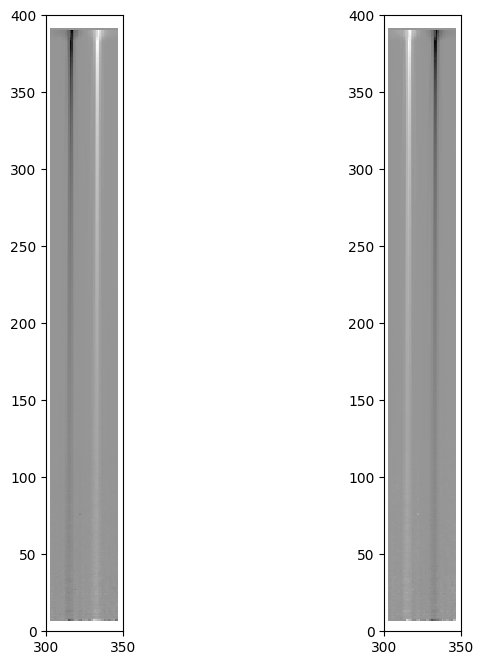

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[8,8])
for sp,ax in zip(sp2_out, axes):
    ax.imshow(sp.data, origin='lower', interpolation='None', cmap='Greys')
    ax.set_xlim(300,350)
    ax.set_ylim(0,400)

fig.show()

### Suggested modifications

* As we are only modifying the default setting for the `resample_spec` and `extract_1d` steps in the above call, a simpler way to run the above is this:

sp2_out = Spec2Pipeline.call(sp2_asnfile, save_results=True, output_dir='data/', steps={
    'resample_spec': {'skip': True},
    'extract_1d': {'skip': True}})

* To run an individual file through the Spec2Pipeline, replace the above call by this:

sp2_out = Spec2Pipeline.call(**your_file_here_rate.fits**, save_results=True, output_dir='data/', steps={
                                'assign_wcs': {'skip': False},
                                'bkg_subtract': {'skip': False},
                                'srctype': {'skip': False},
                                'flat_field': {'skip': False},
                                'pathloss': {'skip': False},
                                'photom': {'skip': False},
                                'pixel_replace': {'skip': False},
                                'resample_spec': {'skip': True},
                                'extract_1d': {'skip': True}})

* To run the Spec2Pipeline with a new wavelength calibration reference file, replace the above call by this:

sp2_out = Spec2Pipeline.call(sp2_asnfile, save_results=True, output_dir='data/', steps={
                                'assign_wcs': {'skip': False, **override_specwcs='your_new_file.fits'**},
                                'bkg_subtract': {'skip': False},
                                'srctype': {'skip': False},
                                'flat_field': {'skip': False},
                                'pathloss': {'skip': False},
                                'photom': {'skip': False},
                                'pixel_replace': {'skip': False},
                                'resample_spec': {'skip': True},
                                'extract_1d': {'skip': True}})

Similar overrides exist for steps `flat_field`, `photom`, `pathloss` and `extract_1d`. 

## 3. Building the Level 3 Association

The Spec3Pipeline **only** accepts an association as input. So even if you want to take a single file through to Level 3, you have to create an association with a single member, and pass that to the step call. In our case, we want to combine the nods, so we add both cal files into an association. 

The Spec3Pipeline executes the following steps by default:
* `outlier_detection`: the nods are analysed together to identify any remaining outlier pixels
* `resample_spec`: nods are combined and resampled into a single, rectified 2D image
* `extract_1d`: the spectrum is extracted

In [8]:
cal_files = [os.path.join('data/', sp.meta.filename) for sp in sp2_out]
print(cal_files)

asn3 = asn_from_list(cal_files, rule=DMS_Level3_Base, product_name='PID1538_Obs21_end2end_demo', meta={'program':'01538', 'asn_id': 'o021', 'target':'GSPC P330E', 'asn_pool':'None'})

with open('lrs_slit_end2end_spec3asn.json', 'w') as fp:
    fp.write(asn3.dump()[1])



2023-11-13 19:03:49,731 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst1.12.3/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-13 19:03:49,731 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-13 19:03:49,732 - stpipe - WARNING - 


['data/jw01538021001_05101_00001_mirimage_cal.fits', 'data/jw01538021001_05101_00002_mirimage_cal.fits']


In [9]:
sp3_asnfile = 'lrs_slit_end2end_spec3asn.json'

sp3_out = Spec3Pipeline.call(sp3_asnfile, save_results=True, output_dir='data/', steps={
                             'outlier_detection': {'skip': False, 'weight_type': 'ivm'},
                             'resample_spec': {'skip': False, 'weight_type': 'ivm'},
                             'extract_1d': {'skip': False}})

2023-11-13 19:03:49,874 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_pars-spec3pipeline_0001.asdf
2023-11-13 19:03:49,889 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2023-11-13 19:03:49,890 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2023-11-13 19:03:49,890 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2023-11-13 19:03:49,891 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2023-11-13 19:03:49,892 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2023-11-13 19:03:49,893 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2023-11-13 19:03:49,894 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2023-11-13 19:03:49,895 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2023-11-13 19:

In [10]:
x1ds = glob.glob('data/PID1538_Obs21_end2end*x1d.fits')
print(x1ds)

['data/PID1538_Obs21_end2end_demo_x1d.fits']


2023-11-13 19:03:57,707 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_99104/806937497.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
2023-11-13 19:03:57,708 - stpipe - WARNING -   fig.show()
2023-11-13 19:03:57,708 - stpipe - WARNING - 


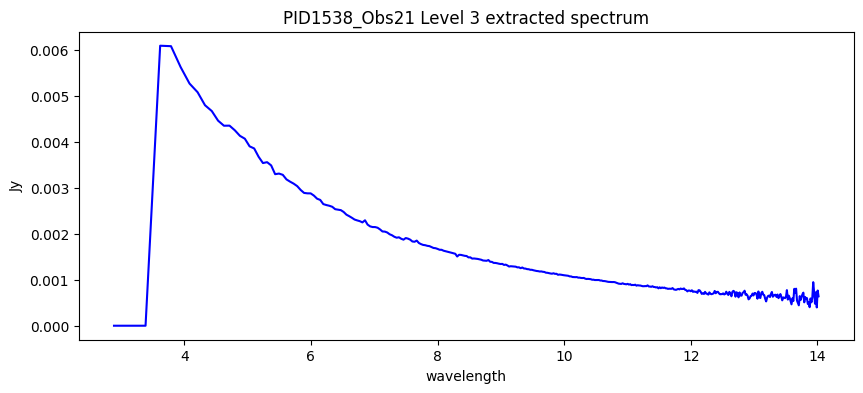

In [11]:
x1d = datamodels.open(x1ds[0])

fig, ax = plt.subplots(figsize=[10,4])
ax.plot(x1d.spec[0].spec_table['WAVELENGTH'], x1d.spec[0].spec_table['FLUX'], 'b-')
ax.set_xlabel('wavelength')
ax.set_ylabel('Jy')
ax.set_title('PID1538_Obs21 Level 3 extracted spectrum')
fig.show()

### Suggested modifications

* There is evidence that the variance arrays for LRS spectroscopy data is not being correctly computed by the calibration pipeline; at the time of writing this is under careful investigation (see [this page](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/known-issues-with-jwst-data-products#KnownIssueswithJWSTDataProducts-MIRIlowresolutionspectroscopy(LRS)) for latest updates). As a result, however, the 'ivm' ('ivm' = inverse variance mapping) weighting setting in the `resample_spec` step may be introducing spurious noise. If the `s2d` output product looks noisy or contains unusual structure, it is worthwhile re-running the Spec3Pipeline with the 'exptime' weighing set. 

* The `extract_1d` uses a simple fixed-width rectangular extraction aperture, however the calibration pipeline has more advanced capabilities. For demonstrations of additional extraction methods, see the `miri_lrs_pipeline_extraction` notebook in this repository.  

END

-- Last Updated: 13 Nov 2023 (S. Kendrew)